In [1]:
# =================================================================================
# 1-1. Library Import 
# =================================================================================
import os
import copy
import random
import time
import io
import contextlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# fvcore (optional)
try:
    from fvcore.nn import FlopCountAnalysis
    FVCORE_AVAILABLE = True
except Exception:
    FlopCountAnalysis = None
    FVCORE_AVAILABLE = False

In [2]:
# =================================================================================
# 1-2. Define CONFIG 
# =================================================================================

CONFIG = {
    # ---------------------------
    # Reproducibility / Experiment ID
    # ---------------------------
    "seed": 42,
    "dataset_name": "UCI-HAR",

    # ---------------------------
    # Data / Split
    # ---------------------------
    "data_dir": "C://Users/park9/CBAM_HAR/UCI-HAR/data", 
    "val_ratio": 0.2,  # UCI-HAR: train split -> train/val portion
    "batch_size": 128,  # dataloader

    # ---------------------------
    # Training
    # ---------------------------
    "epochs": 100,
    "learning_rate": 5e-4,
    "weight_decay": 1e-4,
    "contrast_weight": 0.25,  # total_loss = CE + contrast_weight * contrast_loss
    "scheduler_type": "cosine", # scheduler (CosineAnnealingLR)
    "scheduler_T_max": 100,  # CosineAnnealingLR(T_max=EPOCHS)

    # ---------------------------
    # Model architecture (UCI-HAR)
    # ---------------------------
    "in_channels": 9,        # 9 inertial signals (acc/gyro/total xyz)
    "seq_len": 128,          # window length
    "n_classes": 6,          # HAR classes
    "n_prototypes": 6,       # prototype counts

    "embed_dim": 64,         # Conv1d -> Transformer base dim
    "reduced_dim": 32,       # if we use_dim_reduction == True
    "use_dim_reduction": False,

    "n_heads": 8,            # multi-head attention heads in CrossFormer block
    "dropout": 0.1,

    "kernel_size": 11,       # kernel sizes used in Conv1d embedding and CBAM temporal attention

    # ---------------------------
    # Feature toggles (ablations)
    # ---------------------------
    "use_cbam": True,        # CBAM
    "use_crossformer": True, # CrossFormerBlock
    "use_contrast": True,    # include contrastive prototype loss during training

    # ---------------------------
    # Contrast / Prototype behavior
    # ---------------------------
    "temperature": 0.05,     # temperature in contrastive loss

    # ---------------------------
    # Logging / Debug convenience
    # ---------------------------
    "print_every": 25,        # print every or bumped epoch
    "do_tsne": True,        # t-SNE
    "profile_model": True,  # FLOPs / Params
}

def pretty_print_config(cfg: dict):
    print("=" * 80)
    print("EXPERIMENT CONFIG")
    print("-" * 80)
    # key alignment
    max_k = max(len(k) for k in cfg.keys())
    for k in sorted(cfg.keys()):
        print(f"{k.ljust(max_k)} : {cfg[k]}")
    print("=" * 80)

In [3]:
# =================================================================================
# 1-3. Reproducibility helpers
# =================================================================================
def seed_everything(seed: int = 42):
    """
    Fix random seeds for reproducibility across random, numpy, torch (cpu & cuda).
    Also configures CuDNN for deterministic behavior.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # cudnn deterministic mode: reproducible but may be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id: int):
    """
    To make DataLoader workers deterministic.
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
# =================================================================================
# 1-4. Dataset: UCI-HAR
# =================================================================================
class UCIHARDataset(Dataset):
    """
    UCI HAR Dataset loader.

    Directory structure (expected):
        data_dir/
          train/
            Inertial Signals/
              body_acc_x_train.txt
              body_acc_y_train.txt
              ...
              total_acc_z_train.txt
            y_train.txt
          test/
            Inertial Signals/
              body_acc_x_test.txt
              ...
            y_test.txt

    Notes:
    - UCI-HAR은 이미 subject-wise로 train/test가 고정되어 제공됨.
      즉 train/ 폴더와 test/ 폴더에 다른 사람들(subjects)이 들어 있음.
    - 우리는 train/ 안에서만 val을 떼어내서 train/val로 쓰고,
      test/는 그대로 최종 generalization 평가용으로 사용.
    - 라벨은 원본이 1~6이라서 여기서 0~5로 shift.
    - 시퀀스 길이 T=128, 채널 수 C=9 (가속도/자이로/total_acc 각각 x/y/z)
    """

    def __init__(self, data_dir: str, train: bool = True):
        subset = "train" if train else "test"

        signal_types = [
            "body_acc_x", "body_acc_y", "body_acc_z",
            "body_gyro_x", "body_gyro_y", "body_gyro_z",
            "total_acc_x", "total_acc_y", "total_acc_z",
        ]  # (N, 9, 128)

        signals = []
        for signal in signal_types:
            filename = os.path.join(
                data_dir,
                subset,
                "Inertial Signals",
                f"{signal}_{subset}.txt"
            )

            with open(filename, 'r') as f:
                data = np.loadtxt(f)  # (N, 128) per channel
            signals.append(data)

        self.X = np.stack(signals, axis=1)  # stack -> (N, 9, 128)

        # label: (N,), values in {1..6} -> shift to {0..5}
        label_file = os.path.join(data_dir, subset, f'y_{subset}.txt')
        with open(label_file, 'r') as f:
            self.y = np.loadtxt(f, dtype=np.int32) - 1  # now {0..5}

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        """
        Returns:
            X_i: torch.FloatTensor, shape (C, T) = (9, 128)
            y_i: torch.LongTensor scalar, shape ()
        """
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx], dtype=torch.long)

In [5]:
class UCIHARAllDataset(Dataset):
    """
    UCI-HAR 전체(train+test)를 한 번에 불러와서 합친 버전.
    subject-wise 분리를 유지하지 않고 윈도우 단위로 다 섞어서 쓸 때 사용.

    결과:
        self.X : (N_all, 9, 128)
        self.y : (N_all,)
    """

    def __init__(self, data_dir: str):
        # 1) train 부분 로드
        train_ds = UCIHARDataset(data_dir, train=True)
        # 2) test 부분 로드
        test_ds  = UCIHARDataset(data_dir, train=False)

        # 3) concat
        self.X = np.concatenate([train_ds.X, test_ds.X], axis=0)  # (N_all, 9, 128)
        self.y = np.concatenate([train_ds.y, test_ds.y], axis=0)  # (N_all,)

        # float / long로 정리
        self.X = self.X.astype(np.float32)
        self.y = self.y.astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),          # (9,128)
            torch.tensor(self.y[idx], dtype=torch.long)     # ()
        )


In [6]:
# =================================================================================
# 2-1. CBAM1D
# =================================================================================
class ChannelAttention1D(nn.Module):
    """
    Channel attention for 1D signals.
    Input shape:  (B, C, T)
    Output shape: (B, C, T) with per-channel reweighting.
    """
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, C, T)
        avg_out = self.avg_pool(x).squeeze(-1)  # (B, C)
        max_out = self.max_pool(x).squeeze(-1)  # (B, C)

        avg_out = self.fc(avg_out)  # (B, C)
        max_out = self.fc(max_out)  # (B, C)

        out = (avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        scale = self.sigmoid(out)  # (B, C, 1)
        return x * scale  # broadcast along T


class TemporalAttention1D(nn.Module):
    """
    Temporal attention for 1D signals.
    Input shape:  (B, C, T)
    Output shape: (B, C, T) with per-timestep reweighting.

    Internally uses a conv over [avg_pool; max_pool] across channels,
    so conv input channel dim is fixed to 2.
    """
    def __init__(self, kernel_size: int = 7):
        super().__init__()

        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(
            in_channels=2,
            out_channels=1,
            kernel_size=kernel_size,
            padding=padding,
            bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)

        attn_in = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        attn_map = self.conv(attn_in)                        # (B, 1, T)
        attn_map = self.sigmoid(attn_map)
        return x * attn_map  # broadcast along C


class CBAM1D(nn.Module):
    """
    CBAM-style attention for 1D sensor sequences.
    Does channel attention -> temporal attention.

    Input / Output shape: (B, C, T)
    """
    def __init__(self, channels: int, reduction: int = 16, kernel_size: int = 7):
        super().__init__()

        self.channel_att = ChannelAttention1D(channels, reduction=reduction)
        self.temporal_att = TemporalAttention1D(kernel_size=kernel_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, C, T)
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x

In [7]:
# =================================================================================
# 2-2. CrossFormer Block (Cross-Attn between tokens and learnable prototypes)
# =================================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self,
                 dim: int,
                 n_prototypes: int = 6,
                 n_heads: int = 4,
                 mlp_ratio: float = 2.0,
                 dropout: float = 0.1,
                 initial_prototypes: torch.Tensor = None):
        """
        Args:
            dim: token embedding dim
            n_prototypes: number of learnable class prototypes
            n_heads: attention heads (must divide dim)
            mlp_ratio: FFN expansion ratio
            dropout: dropout inside MHA/MLP
            initial_prototypes: optional (n_prototypes, dim) tensor to init prototypes
        """
        super().__init__()

        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        # Learnable prototypes
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))

        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print("Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print("Prototypes initialized with Xavier Uniform.")

        # Cross-attention (tokens Q) x (prototypes K,V)
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads,
                                                dropout=dropout, batch_first=True)
        
        # Self-attention on tokens
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads,
                                               dropout=dropout, batch_first=True)
        
        # FFN
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

        # Projection for contrastive proto features
        self.proto_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )

    def forward(self,
                x: torch.Tensor,
                return_proto_features: bool = False,
                skip_cross_attention: bool = False):
        """
        Args:
            x: (B, T, C=dim)
            return_proto_features: if True, also returns pooled/proj features for contrast
            skip_cross_attention: if True, bypass cross-attn (used for proto init feature extraction)
        Returns:
            If return_proto_features:
                (x_out, proto_features, cross_attn_weights)
            else:
                x_out
        """
        B, T, C = x.shape
        attn_weights = None

        # 1) Cross-Attention (optional)
        if not skip_cross_attention:
            # normalize prototypes for stable attention keys/values
            normalized_prototypes = F.normalize(self.prototypes, dim=1, eps=1e-6)  # (P, C)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)  # (B, P, C)

            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out  # residual

        # 2) Self-Attention
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out  # residual

        # 3) FFN
        x = x + self.mlp(self.norm3(x))  # residual

        if return_proto_features:
            proto_features = x.mean(dim=1)  # (B, C)
            proto_features = self.proto_proj(proto_features)  # (B, C)
            return x, proto_features, attn_weights
        
        return x

In [8]:
# =================================================================================
# 2-3. Contrastive Prototype Loss
# =================================================================================
class ContrastivePrototypeLoss(nn.Module):
    """
    Supervised prototype contrast loss.

    For each sample embedding f_i and class prototypes P (1 per class),
    we compute a softmax over cosine similarities and apply cross-entropy
    against the ground truth label.

    Intuition:
      - Pull sample features closer to their class prototype.
      - Push them away from other class prototypes.
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.temperature = temperature

    def forward(
        self,
        features: torch.Tensor,    # (B, D)
        prototypes: torch.Tensor,  # (num_classes, D)
        labels: torch.Tensor       # (B,)
    ) -> torch.Tensor:
        """
        Args:
            features:  batch embeddings (B, D)
            prototypes: class prototype matrix (num_classes, D)
                        usually num_classes == n_prototypes
            labels:    ground-truth class indices, shape (B,), dtype long

        Returns:
            scalar loss (tensor)
        """
        # L2 normalize
        features = F.normalize(features, dim=1, eps=1e-6)
        prototypes = F.normalize(prototypes, dim=1, eps=1e-6)

        # cosine similarity
        logits = torch.matmul(features, prototypes.t()) / self.temperature  # (B, num_classes)

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)
        return loss

In [9]:
# =================================================================================
# 2-4. Final Model: embedding + (CBAM) + CrossFormer + classifier
# =================================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    """
    Sensor sequence classifier with:
      - Conv1d embedding (+ BatchNorm + GELU + Dropout)
      - Optional CBAM (channel & temporal attention)
      - Either:
          (A) CrossFormer block with learnable prototypes
        or
          (B) TransformerEncoderLayer-only self-attention fallback
      - Global average pooling over time
      - MLP classifier head
      - (Optional) contrastive prototype loss

    Args:
        in_channels:   # sensor channels (e.g. 9 for UCI-HAR)
        seq_len:       # sequence length (e.g. 128 for UCI-HAR); mostly for reference / profiling
        embed_dim:     # conv embedding dim (and final feature dim if no reduction)
        reduced_dim:   # reduced dim if use_dim_reduction=True
        n_classes:     # num activity classes
        n_prototypes:  # number of learnable prototypes in CrossFormer
        n_heads:       # attention heads for CrossFormer/self-attn
        kernel_size:   # conv1d kernel size for embedding, and CBAM temporal kernel
        dropout:       # dropout rate
        temperature:   # temperature for contrastive loss
        initial_prototypes:  # tensor to init CrossFormerBlock.prototypes, or None
        use_cbam:      # if True, apply CBAM after embedding
        use_crossformer:     # if True, use CrossFormerBlock; else use vanilla self-attn block
        use_contrast:        # if True, model can return contrastive loss
        use_dim_reduction:   # if True, reduce dim before attention and restore after
    """
    def __init__(self,
                 in_channels: int = 9,
                 seq_len: int = 128,
                 embed_dim: int = 64,
                 reduced_dim: int = 32,
                 n_classes: int = 6,
                 n_prototypes: int = 6,
                 n_heads: int = 8,
                 kernel_size: int = 7,
                 dropout: float = 0.1,
                 temperature: float = 0.07,
                 initial_prototypes: torch.Tensor = None,
                 use_cbam: bool = True,
                 use_crossformer: bool = True,
                 use_contrast: bool = True,
                 use_dim_reduction: bool = False):
        super().__init__()
        
        # Save config
        self.in_channels = in_channels
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.reduced_dim = reduced_dim
        self.n_classes = n_classes
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.temperature = temperature

        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        # 1) Embedding: Conv1d -> BN -> GELU -> Dropout
        #    Input:  (B, in_channels, T)
        #    Output: (B, embed_dim, T)
        self.embedding = nn.Sequential(
            nn.Conv1d(
                in_channels,
                embed_dim,
                kernel_size=kernel_size,
                padding=(kernel_size - 1) // 2,  # "same" padding for odd kernel
            ),
            nn.BatchNorm1d(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        # 2) Optional CBAM
        #    Still (B, embed_dim, T)
        if self.use_cbam:
            self.cbam = CBAM1D(
                channels=embed_dim,
                reduction=8,
                kernel_size=kernel_size,
            )

        # 3) (Optional) Dim Reduction before attention
        #    We'll call this dimension 'working_dim'.
        #    If use_dim_reduction=False, working_dim == embed_dim.
        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        # 4) Attention backbone
        #    A) CrossFormerBlock (our prototype-based block)
        #    B) Fallback: vanilla TransformerEncoderLayer
        #    Input to these blocks: (B, T, working_dim)
        #    Output shape stays (B, T, working_dim)
        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim,
                n_prototypes=n_prototypes,
                n_heads=n_heads,
                mlp_ratio=2.0,
                dropout=dropout,
                initial_prototypes=initial_prototypes,
            )
        else:
            # TransformerEncoderLayer returns same shape (B, T, working_dim)
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim,
                nhead=n_heads,
                dim_feedforward=int(working_dim * 2),
                dropout=dropout,
                batch_first=True,
            )

        # 5) (Optional) Dim restore after attention
        #    Back to embed_dim if we reduced.
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        # 6) Temporal pooling + classifier head
        #    After attention we get (B, T, embed_dim)
        #    -> transpose to (B, embed_dim, T)
        #    -> AdaptiveAvgPool1d(1) -> (B, embed_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes),
        )

        # 7) Contrastive loss module (optional)
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)


    def forward(self,
                x: torch.Tensor,
                labels: torch.Tensor = None,
                return_contrast_loss: bool = False):
        """
        Args:
            x: (B, C_in, T)  e.g. (B, 9, 128)
            labels: (B,) long tensor with class indices [0..n_classes-1]
            return_contrast_loss: if True, we also compute contrastive loss

        Returns:
            if return_contrast_loss and use_contrast:
                (logits, contrast_loss)
            else:
                logits
        """
        # 1) Conv embedding (+CBAM)
        x = self.embedding(x)

        if self.use_cbam:
            x = self.cbam(x)

        # 2) Prepare for attention
        #    (B, embed_dim, T) -> (B, T, embed_dim)
        #    Optionally reduce dim
        x = x.transpose(1, 2).contiguous()

        if self.use_dim_reduction:
            x = self.dim_reduce(x)

        # 3) Attention backbone
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(x, return_proto_features=True,
                                                        skip_cross_attention=False)
            else:
                x = self.crossformer(x, return_proto_features=False,
                                     skip_cross_attention=False)
        else:
            x = self.self_attn(x)

        # 4) Restore dim if reduced
        if self.use_dim_reduction:
            x = self.dim_restore(x)

        # 5) Pool over time
        #    (B, T, embed_dim) -> (B, embed_dim, T) -> pool -> (B, embed_dim)
        x = x.transpose(1, 2).contiguous()
        feat_vec = self.pool(x).squeeze(-1)

        # 6) Classifier
        logits = self.classifier(feat_vec)

        # 7) Optional contrastive term
        if (
            return_contrast_loss
            and self.use_contrast
            and proto_features is not None
            and labels is not None
        ):
            contrast_loss = self.contrast_loss(
                proto_features,                # (B, dim)
                self.crossformer.prototypes,   # (n_prototypes, dim)
                labels                         # (B,)
            )
            return logits, contrast_loss

        return logits

In [10]:
# =================================================================================
# 2-5. Prototype Initialization
# =================================================================================
def get_mean_prototypes(train_full_dataset, device, config):

    temp_model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        seq_len=config['seq_len'],
        n_classes=config['n_classes'],
        n_prototypes=config['n_prototypes'],
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'], 
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        temperature=config['temperature'],
        initial_prototypes=None,
        use_cbam=config["use_cbam"],
        use_crossformer=config["use_crossformer"],
        use_contrast=False,  # 중요: 여기서는 contrast loss 안 씀
        use_dim_reduction=config['use_dim_reduction']
    ).to(device)

    temp_model.eval()

    temp_loader = DataLoader(
        train_full_dataset,
        batch_size=config["batch_size"],  # CONFIG 키 맞춤 (BATCH_SIZE -> batch_size)
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    all_features, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)

            x = temp_model.embedding(batch_x)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)

            x = x.transpose(1, 2).contiguous()

            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)

            if temp_model.use_crossformer:
                x = temp_model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=True
                )                                   # (B, T, working_dim)
            else:
                x = temp_model.self_attn(x)         # (B, T, working_dim)

            # Dim restore (if reduction was used)
            if temp_model.use_dim_reduction:
                x = temp_model.dim_restore(x)       # (B, T, embed_dim)

            x = x.transpose(1, 2).contiguous()  # (B, embed_dim, T)

            pooled_features = temp_model.pool(x).squeeze(-1)  # (B, embed_dim)

            all_features.append(pooled_features.cpu())  # (N, embed_dim)
            all_labels.append(batch_y.cpu())  # (N,)

    num_classes = config["n_classes"]
    feature_dim = config["embed_dim"]  # pooled_features의 dim과 맞춰줌

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    mean_prototypes = torch.zeros(num_classes, feature_dim, dtype=torch.float32)
    for i in range(num_classes):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            mean_prototypes[i] = torch.randn(feature_dim)
    
    return mean_prototypes.to(device)

In [11]:
# =================================================================================
# 3-1. train & evaluation
# =================================================================================
def train_epoch(model,
                dataloader,
                criterion,
                optimizer,
                device,
                use_contrast=True,
                contrast_weight=0.5):
    model.train()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            total_loss = ce_loss + contrast_weight * contrast_loss
            contrast_loss_sum  += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            total_loss  = ce_loss

        total_loss.backward()
        optimizer.step()

        total_loss_sum  += total_loss.item()
        ce_loss_sum  += ce_loss.item()

        preds = logits.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(batch_y.detach().cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_total_loss = total_loss / len(dataloader)
    avg_ce_loss = ce_loss_sum  / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum  > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model,
             dataloader,
             criterion,
             device,
             use_contrast=True,
             contrast_weight=0.5):
    model.eval()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)

            # Forward (eval 모드에서는 no_grad)
            if use_contrast and model.use_contrast and model.use_crossformer:
                logits, contrast_loss = model(
                    batch_x,
                    batch_y,
                    return_contrast_loss=True
                )
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss + contrast_weight * contrast_loss
                contrast_loss_sum += contrast_loss.item()
            else:
                logits = model(batch_x)
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss

            total_loss_sum  += total_loss.item()
            ce_loss_sum += ce_loss.item()

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

        torch.cuda.synchronize()

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, acc, f1, all_preds, all_labels, avg_ce_loss, avg_contrast_loss

In [12]:
# =================================================================================
# 4-1. Confusion Matrix & t-SNE
# =================================================================================

# UCI-HAR LABELS
ACTIVITY_LABELS_CM = [
    "Walking",
    "Walking Upstairs".replace(" ", "\n"),
    "Walking Downstairs".replace(" ", "\n"),
    "Sitting",
    "Standing",
    "Lying",
]

def plot_classification_results(y_true, y_pred, save_path=None):
    """
    Confusion Matrix 시각화 
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS_CM,
            digits=4,
            zero_division=0,
        )
    )

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 22}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)
    plt.xlabel('Predicted Label', fontsize=12.5)
    plt.ylabel('True Label', fontsize=11)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path.replace('.png', '.pdf')
        plt.savefig(pdf_save_path, dpi=600)

    plt.show()
    plt.close()


def _extract_featvec_before_classifier(model, xb, device):
    """
    model.forward()의 흐름을 그대로 따라가되
    classifier 직전의 feature vector(feat_vec, shape (B, embed_dim))만 추출.
    이건 visualize_tsne에서 feature space로 쓸 거임.

    xb: (B, C_in, T) on CPU
    returns: (B, embed_dim) on CPU (no grad)
    """
    xb = xb.to(device)

    # 1. Embedding (+CBAM)
    x = model.embedding(xb)                  # (B, embed_dim, T)
    if model.use_cbam:
        x = model.cbam(x)                    # (B, embed_dim, T)

    # 2. 준비: (B, C, T) -> (B, T, C)
    x = x.transpose(1, 2).contiguous()       # (B, T, embed_dim)

    # 3. Dim reduction (optional)
    if model.use_dim_reduction:
        x = model.dim_reduce(x)              # (B, T, reduced_dim)

    # 4. Attention backbone
    if model.use_crossformer:
        # contrast 안 쓸 거라 proto_features 필요 없음
        # eval 시에는 실제 inference 경로로 skip_cross_attention=False 가 더 정직
        x = model.crossformer(
            x,
            return_proto_features=False,
            skip_cross_attention=False
        )                                    # (B, T, working_dim)
    else:
        # fallback self-attention
        x = model.self_attn(x)               # (B, T, working_dim)

    # 5. Dim restore (optional)
    if model.use_dim_reduction:
        x = model.dim_restore(x)             # (B, T, embed_dim)

    # 6. Pooling과 동일하게 처리
    # (B, T, embed_dim) -> (B, embed_dim, T)
    x = x.transpose(1, 2).contiguous()       # (B, embed_dim, T)
    feat_vec = model.pool(x).squeeze(-1)     # (B, embed_dim)

    return feat_vec.detach().cpu()           # CPU로 반환, grad 없이


ACTIVITY_LABELS = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Lying",
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

def visualize_tsne(model, dataloader, device, save_path=None, max_points=2000):
    """
    모델의 최종 분류기 직전 임베딩(feat_vec)을 모아서 t-SNE로 2D 시각화.

    - dataloader: 보통 val_loader나 test_loader 넣는 걸 추천
    - max_points: t-SNE에 넣을 최대 샘플 수 (메모리 / 시각화 과부하 방지)
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader):
            # xb: (B, C, T) on CPU
            # yb: (B,)
            feat_vec = _extract_featvec_before_classifier(model, xb, device)  # (B, embed_dim) on CPU
            all_features.append(feat_vec.numpy())
            all_labels.append(yb.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)  # (N, D)
    all_labels = np.concatenate(all_labels, axis=0)      # (N,)

    # 샘플 수 줄이기 (max_points 초과 시 랜덤 샘플)
    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]  # (M, D)
    y_sel = all_labels[idx]    # (M,)

    # perplexity는 (샘플 수 - 1)보다 작아야 함
    # 너무 작으면 이상해지니 최소 5 정도로 clamp
    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)  # (M, 2)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40, 
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path.replace('.png', '.pdf')
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, device, save_path=None, max_points=2000):
    """
    모델을 거치기 전의 raw window (shape: B x C x T)를 flatten해서 t-SNE로 투영.

    - dataloader: 보통 val_loader나 test_loader 넣는 걸 추천 (train 넣으면 class 간경계 너무 깨끗하게 나오는 경우 많음)
    - max_points: t-SNE에 사용할 최대 샘플 수
    """
    all_raw = []
    all_labels = []

    for xb, yb in tqdm(dataloader):
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    # 샘플 수 줄이기
    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]    # (M, C, T)
    y_sel = all_labels[idx] # (M,)

    # flatten: (M, C*T)
    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40, 
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path.replace('.png', '.pdf')
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()

In [13]:
# =================================================================================
# 4-2. Model profiling: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model,
                  sample_input: torch.Tensor,
                  device: torch.device,
                  warmup: int = 10,
                  iters: int = 50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M 단위)
      - FLOPs per sample (M 단위, fvcore 있으면)
      - 평균 추론 시간 (ms / sample)

    fvcore가 stdout/stderr에 시끄럽게 프린트하는 걸 다 먹어버린다.
    """

    model = model.to(device)
    model.eval()

    # -------------------------------------------------
    # 1) 파라미터 수
    # -------------------------------------------------
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6  # million params

    # -------------------------------------------------
    # 2) FLOPs 측정 (fvcore 사용 가능할 때만)
    #    - 모든 stdout/stderr을 임시 버퍼로 리다이렉트해서
    #      "Unsupported operator ..." 같은 중얼거림을 완전히 감춘다.
    # -------------------------------------------------
    flops_m = None
    if "FVCORE_AVAILABLE" in globals() and FVCORE_AVAILABLE and FlopCountAnalysis is not None:
        try:
            with torch.no_grad():
                fake_out = io.StringIO()
                fake_err = io.StringIO()
                with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                    flops = FlopCountAnalysis(model, (sample_input.to(device),))
                    total_flops = flops.total()
            flops_m = total_flops / 1e6  # to millions
        except Exception:
            flops_m = None
    else:
        flops_m = None

    # -------------------------------------------------
    # 3) 추론 시간 측정
    # -------------------------------------------------
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }



def print_model_profile(stats_dict):
    print("=" * 80)
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=" * 80)

DataSet : UCI-HAR
Device : cuda
EXPERIMENT CONFIG
--------------------------------------------------------------------------------
batch_size        : 128
contrast_weight   : 0.25
data_dir          : C://Users/park9/CBAM_HAR/UCI-HAR/data
dataset_name      : UCI-HAR
do_tsne           : True
dropout           : 0.1
embed_dim         : 64
epochs            : 100
in_channels       : 9
kernel_size       : 11
learning_rate     : 0.0005
n_classes         : 6
n_heads           : 8
n_prototypes      : 6
print_every       : 25
profile_model     : True
reduced_dim       : 32
scheduler_T_max   : 100
scheduler_type    : cosine
seed              : 42
seq_len           : 128
temperature       : 0.05
use_cbam          : True
use_contrast      : True
use_crossformer   : True
use_dim_reduction : False
val_ratio         : 0.2
weight_decay      : 0.0001
Prototypes initialized with Xavier Uniform.


Prototype Init: 100%|██████████| 49/49 [00:00<00:00, 117.66it/s]


Prototypes initialized with calculated mean features.
Parameters: 71,068


[025/100]
  train | total=0.0016  ce=0.0605  ct=0.0633  acc=0.9746  f1=0.9746
  val   | total=0.0701  ce=0.0555  ct=0.0583  acc=0.9752  f1=0.9752


[050/100]
  train | total=0.0027  ce=0.0383  ct=0.0394  acc=0.9849  f1=0.9850
  val   | total=0.0569  ce=0.0456  ct=0.0450  acc=0.9811  f1=0.9810


[075/100]
  train | total=0.0004  ce=0.0183  ct=0.0191  acc=0.9935  f1=0.9935
  val   | total=0.0523  ce=0.0420  ct=0.0410  acc=0.9849  f1=0.9849


[100/100]
  train | total=0.0000  ce=0.0162  ct=0.0161  acc=0.9943  f1=0.9943
  val   | total=0.0567  ce=0.0458  ct=0.0436  acc=0.9849  f1=0.9849

[Training Complete!]
  Best Val Acc: 0.9874 @ epoch 78
  Test (best val ckpt): acc=0.9874, f1=0.9874, total_loss=0.0452, ce=0.0360, ct=0.0366
Parameters      : 0.0711 M
FLOPs / sample : 4.253 M
Infer Time     : 3.11 ms/sample

Classification Report
                    precision    recall  f1-score   support

           Walking     1.0000    1.0000    1.0000       321
  Walking
Upstairs     0.9970    1.0000    0.9985       334
Walking
Downstairs     1.0000    1.0000    1.0000       285
           Sitting     0.9773    0.9504    0.9637       363
          Standing     0.9547    0.9781    0.9663       366
             Lying     1.0000    1.0000    1.0000       392

          accuracy                         0.9874      2061
         macro avg     0.9882    0.9881    0.9881      2061
      weighted avg     0.9875    0.9874    0.9874      2061



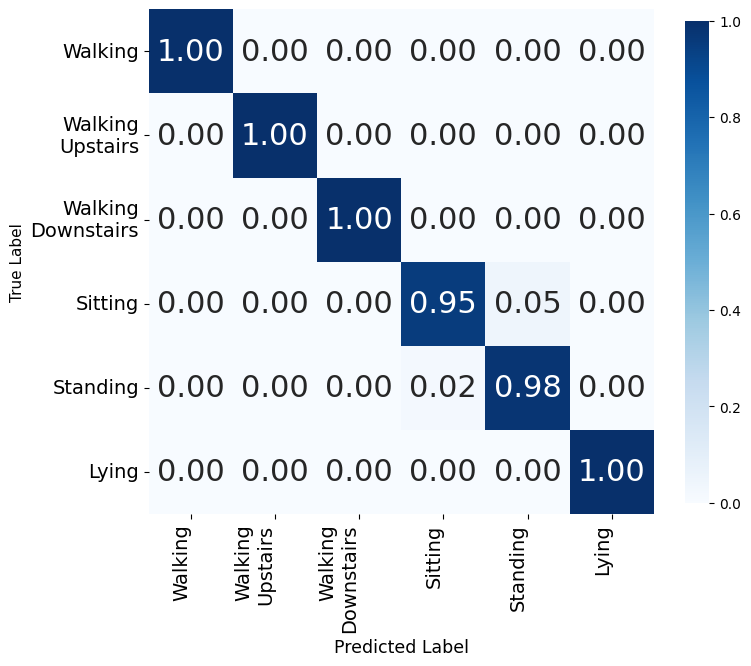

100%|██████████| 17/17 [00:00<00:00, 190.87it/s]


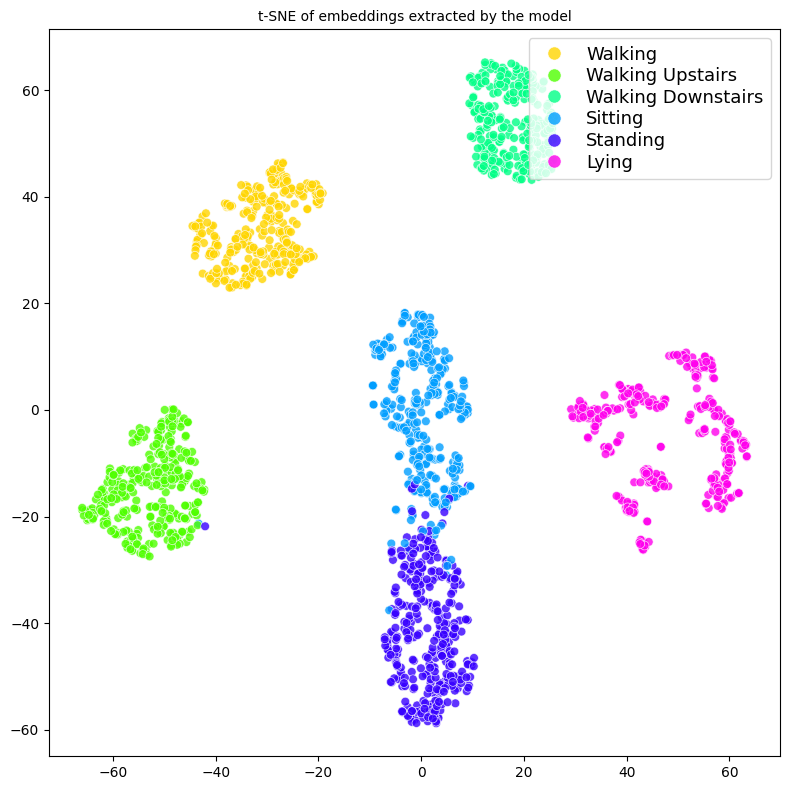

100%|██████████| 17/17 [00:00<00:00, 551.84it/s]


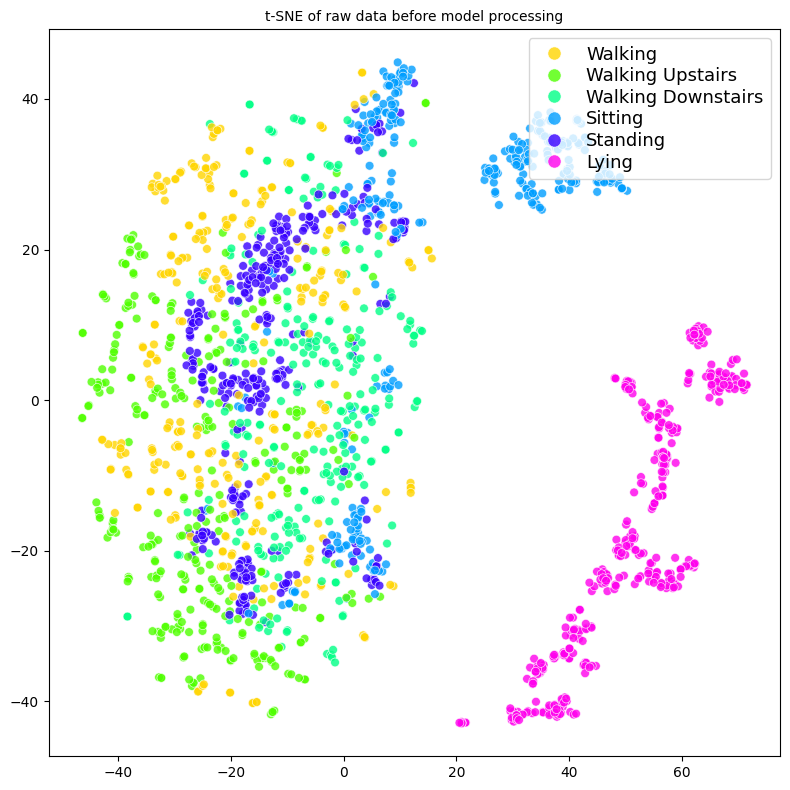

In [14]:
# =====================================================================
# 5. Main
# =====================================================================
def main():
    # -----------------------------
    # Device / SEED
    # -----------------------------
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed_everything(CONFIG["seed"])

    print("=" * 80)
    print("DataSet : UCI-HAR")
    print(f"Device : {DEVICE}")
    print("=" * 80)
    pretty_print_config(CONFIG)

    # -------------------------------------------------
    # 1) 전체 데이터 (train+test 합침)
    # -------------------------------------------------
    full_dataset = UCIHARAllDataset(CONFIG["data_dir"])
    N = len(full_dataset)

    # 60/20/20 윈도우 단위 랜덤 분할
    idx_all = np.arange(N)
    rng = np.random.default_rng(CONFIG["seed"])
    rng.shuffle(idx_all)

    n_train = int(0.6 * N)
    n_val   = int(0.2 * N)
    train_idx = idx_all[:n_train]
    val_idx   = idx_all[n_train:n_train+n_val]
    test_idx  = idx_all[n_train+n_val:]

    from torch.utils.data import Subset
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset   = Subset(full_dataset, val_idx)
    test_dataset  = Subset(full_dataset, test_idx)

    # -----------------------------
    # DataLoader
    # -----------------------------
    g = torch.Generator().manual_seed(CONFIG["seed"])

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        num_workers=0,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    # -----------------------------
    # Initialize Prototypes
    # -----------------------------
    initial_prototypes = get_mean_prototypes(
        train_dataset,
        DEVICE,
        CONFIG
    )

    # -----------------------------
    # Create Model
    # -----------------------------
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=CONFIG["in_channels"],
        seq_len=CONFIG["seq_len"],
        embed_dim=CONFIG["embed_dim"],
        reduced_dim=CONFIG["reduced_dim"],
        n_classes=CONFIG["n_classes"],
        n_prototypes=CONFIG["n_prototypes"],
        n_heads=CONFIG["n_heads"],
        kernel_size=CONFIG["kernel_size"],
        dropout=CONFIG["dropout"],
        temperature=CONFIG["temperature"],
        initial_prototypes=initial_prototypes,  # mean proto init
        use_cbam=CONFIG["use_cbam"],
        use_crossformer=CONFIG["use_crossformer"],
        use_contrast=CONFIG["use_contrast"],
        use_dim_reduction=CONFIG["use_dim_reduction"],
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")
    print("=" * 80)

    # -----------------------------
    # optimizer / scheduler / criterion
    # -----------------------------
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG["scheduler_T_max"],
    )

    # -----------------------------
    # Train Loop
    # -----------------------------
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    history = []
    
    for epoch in range(CONFIG["epochs"]):
        # 1) train
        train_total, train_ce, train_ct, train_acc, train_f1 = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # 2) val  
        val_total, val_acc, val_f1, _, _, val_ce, val_ct = evaluate(
            model,
            val_loader,
            criterion,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # 3) scheduler step
        if scheduler is not None:
            scheduler.step()

        # 4) 기록
        history.append({
            "epoch": epoch + 1,
            "train_total": train_total,
            "train_ce": train_ce,
            "train_ct": train_ct,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_total": val_total,
            "val_ce": val_ce,
            "val_ct": val_ct,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # 5) best ckpt 추적 (val acc 기준)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        # 6) 로깅 (print_every 기준)
        if (epoch + 1) % CONFIG["print_every"] == 0:
            ep_now   = epoch + 1
            ep_total = CONFIG["epochs"]

            print(f"[{ep_now:03d}/{ep_total:03d}]")
            print(
                "  train | "
                f"total={train_total:.4f}  "
                f"ce={train_ce:.4f}  "
                f"ct={train_ct:.4f}  "
                f"acc={train_acc:.4f}  "
                f"f1={train_f1:.4f}"
            )
            print(
                "  val   | "
                f"total={val_total:.4f}  "
                f"ce={val_ce:.4f}  "
                f"ct={val_ct:.4f}  "
                f"acc={val_acc:.4f}  "
                f"f1={val_f1:.4f}"
            )

    # -------------------------------------------------
    # Load Best ckpt 
    # -------------------------------------------------
    assert best_state is not None, "Training loop didn't save any best_state."
    model.load_state_dict(best_state)

    # -------------------------------------------------
    # Final Test by Best ckpt
    # -------------------------------------------------
    test_total, test_acc, test_f1, test_preds, test_labels, test_ce, test_ct = evaluate(
        model,
        test_loader,
        criterion,
        DEVICE,
        use_contrast=CONFIG["use_contrast"],
        contrast_weight=CONFIG["contrast_weight"],
    )

    print("=" * 80)
    print("\n[Training Complete!]")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(
        f"  Test (best val ckpt): "
        f"acc={test_acc:.4f}, f1={test_f1:.4f}, "
        f"total_loss={test_total:.4f}, ce={test_ce:.4f}, ct={test_ct:.4f}"
    )
    
    # -----------------------------
    # model profile
    # -----------------------------
    if CONFIG["profile_model"]:
        dummy_input = torch.randn(
            1,
            CONFIG["in_channels"],
            CONFIG["seq_len"],
        )
        stats = profile_model(model, dummy_input, DEVICE)
        print_model_profile(stats)

    # -----------------------------
    # Visualize CM, t-SNE
    # -----------------------------
    plot_classification_results(
        test_labels,
        test_preds,
        save_path="confusion_matrix.png"
    )

    if CONFIG["do_tsne"]:
        visualize_tsne(
            model,
            test_loader,
            DEVICE,
            save_path="tsne_feature.png",
        )

        visualize_tsne_raw(
            test_loader,
            DEVICE,
            save_path="tsne_raw.png",
        )

if __name__ == "__main__":
    main()